### Importing Required Packages

In [1]:
import json
import csv
import requests
import pprint
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import os.path
from sklearn.externals.joblib import Memory
from hmmlearn import hmm

### Declaring API Keys and Global Variables

In [2]:
# Declaring API Keys Used
places_api_web_service =  'PLACES_API_KEY'
geocoding_api = 'GEOCODING_API_KEY'

In [3]:
# Declaring Global Variables Used
pause = 0.1
max_api_requests = 150000 
api_requests_count = 0
pp = pprint.PrettyPrinter(indent=4)

### Cleaning Raw JSON Data of Google Location History and storing it into CSV File

In [4]:
# Specifying Input and Output Data Files
input_jsonFile = 'Location History.json'
output_csvFile = 'GoogleLocationHistory.csv'

In [5]:
# Loading Data from JSON File
data = json.load(open(input_jsonFile))

In [6]:
# Writing Header Row in Output CSV File
with open(output_csvFile, 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    heading = ["timestampMs", "latitude", "longitude", "accuracy"]
    wr.writerow(heading)

In [7]:
# Writing Relevant Details from JSON File to Output CSV File Row-Wise
with open(output_csvFile, 'a') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    
    for locs in data["locations"]:
        valList = [None] * 4
        for key, value in locs.items():
            if key == "timestampMs":
                valList[0] = value
            elif key == "latitudeE7":
                valList[1] = (value*1.0)/(10**7)
            elif key == "longitudeE7":
                valList[2] = (value*1.0)/(10**7)
            elif key == "accuracy":
                valList[3] = value
        wr.writerow(valList)

### Intial Dataset after Performing Basic Cleaning Operations

In [8]:
df = pd.read_csv(output_csvFile, header=0)
initial_size = df.shape[0]

In [9]:
print("Total number of records in dataset initially is: " + str(initial_size))

print("\nIntial dataset after performing basic cleaning operations is as follows: ")
df.head(15)

Total number of records in dataset initially is: 229051

Intial dataset after performing basic cleaning operations is as follows: 


,timestampMs,latitude,longitude,accuracy
0,1521567823627,30.397125,78.074604,23
1,1521567763587,30.397125,78.074604,23
2,1521567703564,30.397125,78.074604,23
3,1521567643547,30.397125,78.074604,23
4,1521567582418,30.397154,78.074587,24
5,1521567521337,30.397154,78.074587,24
6,1521567441868,30.397154,78.074587,24
7,1521567357040,30.397154,78.074587,24
8,1521567265569,30.397141,78.074576,22
9,1521567205413,30.397141,78.074576,22


### Mapping the Entire Dataset 

In [10]:
# Specifing the colors used for different aspects of World Map
land_color = '#f5f5f3'
water_color = '#cdd2d4'
coastline_color = '#f5f5f3'
border_color = '#bbbbbb'
meridian_color = '#f5f5f3'
marker_fill_color = '#cc3300'
marker_edge_color = 'None'

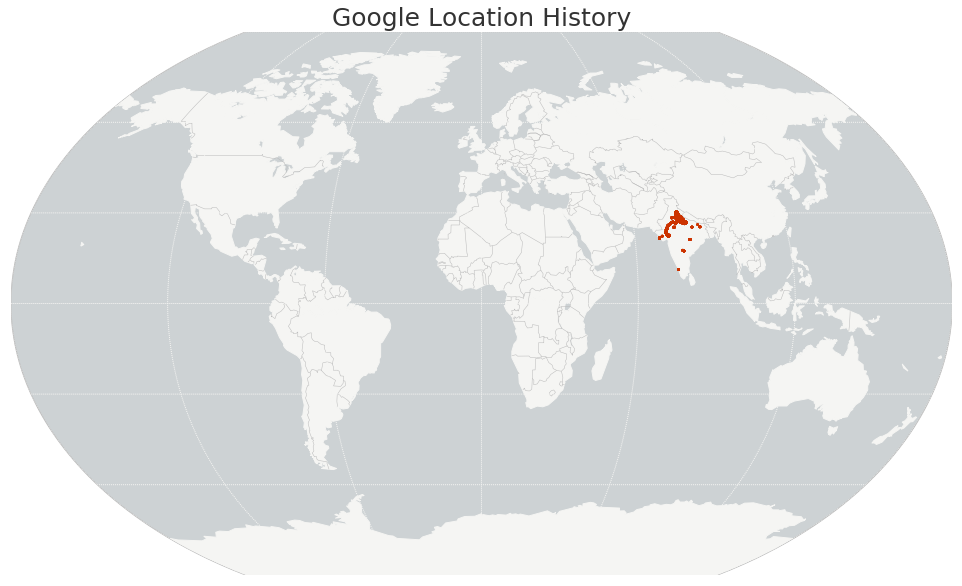

In [11]:
# Create the Plot
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, frame_on=False)
ax.set_title('Google Location History', fontsize=25, color='#333333')


# Draw the Basemap and its Features
m = Basemap(projection='kav7', lon_0=0, resolution='c', area_thresh=10000)
m.drawmapboundary(color=border_color, fill_color=water_color)
m.drawcoastlines(color=coastline_color)
m.drawcountries(color=border_color)
m.fillcontinents(color=land_color, lake_color=water_color)
m.drawparallels(np.arange(-90., 120., 30.), color=meridian_color)
m.drawmeridians(np.arange(0., 420., 60.), color=meridian_color)


# Project the Location History points then Scatter Plot them
x, y = m(df['longitude'].values, df['latitude'].values)
m.scatter(x, y, s=8, color=marker_fill_color, edgecolor=marker_edge_color, alpha=1, zorder=3)


# Show the Map
plt.show()

### Removing Duplicate Records (Latitude - Longitude Pairs)

In [12]:
df = df.iloc[:, 1:3]
df = df.drop_duplicates()
rows = df.shape[0]

In [13]:
print("Total number of records in dataset after dropping duplicate records is: " + str(rows))

print("\nCurrent dataset after dropping duplicate latitude - longitude pairs is as follows: ")
df.head(15)

Total number of records in dataset after dropping duplicate records is: 42416

Current dataset after dropping duplicate latitude - longitude pairs is as follows: 


,latitude,longitude
0,30.397125,78.074604
4,30.397154,78.074587
8,30.397141,78.074576
15,30.397143,78.074586
21,30.397141,78.074569
22,30.397138,78.074591
24,30.397146,78.074570
29,30.397103,78.074592
34,30.397097,78.074594
35,30.397089,78.074566


### Bar Graph to depict the reduction of size of dataset after dropping duplicate records

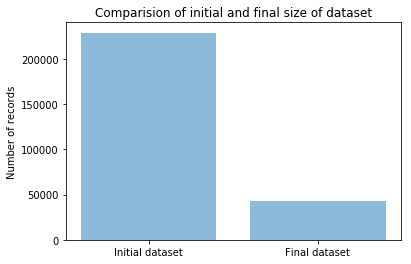

In [14]:
objects = ('Initial dataset', 'Final dataset')
y_pos = np.arange(len(objects))

performance = [initial_size, rows]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number of records')
plt.title('Comparision of initial and final size of dataset')
 
plt.show()

### Inserting New and Blank Fields in the Data Frame

In [15]:
df['latlng'] = df.latitude.astype(str).str.cat(df.longitude.astype(str), sep=',')
df['name'] = ''
df['type'] = ''
df['delete_record'] = ''

In [16]:
print("Modified dataset after inserting new field and blank fields is as follows:")
df.head(15)

Modified dataset after inserting new field and blank fields is as follows:


,latitude,longitude,latlng,name,type,delete_record
0,30.397125,78.074604,"30.397124800000004,78.07460440000001",,,
4,30.397154,78.074587,"30.397153999999997,78.07458670000001",,,
8,30.397141,78.074576,"30.3971412,78.07457579999999",,,
15,30.397143,78.074586,"30.3971434,78.0745858",,,
21,30.397141,78.074569,"30.3971407,78.0745689",,,
22,30.397138,78.074591,"30.397137899999997,78.07459109999999",,,
24,30.397146,78.074570,"30.3971456,78.0745703",,,
29,30.397103,78.074592,"30.3971027,78.07459159999999",,,
34,30.397097,78.074594,"30.3970974,78.0745942",,,
35,30.397089,78.074566,"30.3970894,78.0745662",,,


### List of all possible type of Locations

In [17]:
allowed_types = ['accounting', 'airport', 'amusement_park', 'aquarium', 'art_gallery', 'atm', 'bakery', 'bank', 'bar', 'beauty_salon', 'bicycle_store',
                 'book_store', 'bowling_alley', 'bus_station', 'cafe', 'campground', 'car_dealer', 'car_rental', 'car_repair', 'car_wash', 'casino',
                 'cemetery', 'church', 'city_hall', 'clothing_store', 'convenience_store', 'courthouse', 'dentist', 'department_store', 'doctor',
                 'electrician', 'electronics_store', 'embassy', 'fire_station', 'florist', 'funeral_home', 'furniture_store', 'gas_station', 'gym', 
                 'hair_care', 'hardware_store', 'hindu_temple', 'home_goods_store', 'hospital', 'insurance_agency', 'jewelry_store', 'laundry', 
                 'lawyer', 'library', 'liquor_store', 'local_government_office', 'locksmith', 'lodging', 'meal_delivery', 'meal_takeaway', 'mosque',
                 'movie_rental', 'movie_theater', 'moving_company', 'museum', 'night_club', 'painter', 'park', 'parking', 'pet_store', 'pharmacy',
                 'physiotherapist', 'plumber', 'police', 'post_office', 'real_estate_agency', 'restaurant', 'roofing_contractor', 'rv_park', 'school',
                 'shoe_store', 'shopping_mall', 'spa', 'stadium', 'storage', 'store', 'subway_station', 'supermarket', 'synagogue', 'taxi_stand',
                 'train_station', 'transit_station', 'travel_agency', 'veterinary_care', 'zoo']

### Reverse Geocoding Latitudes and Longitudes inorder to find their corresponding Location Type and other Information

In [18]:
# Specifying the path of Cache File and value of local variable 'radius'
cache_file = "latlong_details.csv"
radius = 5

In [19]:
# Create a Cache File and write Header Row if Cache File does not exist 
if not os.path.exists(cache_file):
    with open(cache_file, 'w') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        heading = ["latlng", "name", "type", "delete_record"]
        wr.writerow(heading)

In [20]:
# Load data from Cache File
cache_df = pd.read_csv(cache_file, header=0)

In [21]:
with open(cache_file, 'a') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    
    for x in range (0, rows):
        latlng = df.iloc[x, 2]

        global api_requests_count
        result = {}
        
        # Check if required 'latlng' details are present in Cache File
        found = False
        
        for y in range(0, cache_df.shape[0]):
            if cache_df.iloc[y, 0] == latlng:
                df.iloc[x, 3] = cache_df.iloc[y, 1]
                df.iloc[x, 4] = cache_df.iloc[y, 2]
                df.iloc[x, 5] = cache_df.iloc[y, 3]
                found = True
                break
    
        # If required 'latlng' details are not present in Cache File then make a reqiured API call and store the result obtained in Cache File
        if (api_requests_count < max_api_requests) and (found == False):  
            time.sleep(pause)
            api_requests_count += 1

            reverse_geocode_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json?location=" + latlng + "&radius=" + str(radius) + "&key=" + places_api_web_service
            
            data = requests.get(reverse_geocode_url).json()
        
            if len(data['results']) > 0:
                result = data['results']
                name = ''
                types = []
            
                for i in range (0, len(result)):
                    name = name + str(result[i]['name']) + " "
                    types = types + result[i]['types']
                
                
                # Determine if the type of Location is present in the list of allowed types. If the type of location is not present in allowed types 
                # then set 'delete_record' field to True
                flag = False
                
                for item in allowed_types:
                    if item in types:
                        types = item
                        flag = True
                        break
                
                df.iloc[x, 3] = name
                df.iloc[x, 4] = str(types)
                df.iloc[x, 5] = (not flag)
                
                valList = [latlng, name, types, not flag]
                wr.writerow(valList)
        elif api_requests_count > max_api_requests:
            break

In [22]:
print("Head of dataset after reverse geocoding is as follows: ")
df.head(25)

Head of dataset after reverse geocoding is as follows: 


,latitude,longitude,latlng,name,type,delete_record
0,30.397125,78.074604,"30.397124800000004,78.07460440000001",Dehradun Raman Hostel Block 1 Bhagwant Pur,"[u'locality', u'political', u'point_of_interes...",True
4,30.397154,78.074587,"30.397153999999997,78.07458670000001",Dehradun Raman Hostel Block 1 Bhagwant Pur,"[u'locality', u'political', u'point_of_interes...",True
8,30.397141,78.074576,"30.3971412,78.07457579999999",Dehradun Raman Hostel Block 1 Bhagwant Pur,"[u'locality', u'political', u'point_of_interes...",True
15,30.397143,78.074586,"30.3971434,78.0745858",Dehradun Raman Hostel Block 1 Bhagwant Pur,"[u'locality', u'political', u'point_of_interes...",True
21,30.397141,78.074569,"30.3971407,78.0745689",Dehradun Raman Hostel Block 1 Bhagwant Pur,"[u'locality', u'political', u'point_of_interes...",True
22,30.397138,78.074591,"30.397137899999997,78.07459109999999",Dehradun Raman Hostel Block 1 Bhagwant Pur,"[u'locality', u'political', u'point_of_interes...",True
24,30.397146,78.074570,"30.3971456,78.0745703",Dehradun Raman Hostel Block 1 Bhagwant Pur,"[u'locality', u'political', u'point_of_interes...",True
29,30.397103,78.074592,"30.3971027,78.07459159999999",Dehradun Raman Hostel Block 1 Bhagwant Pur,"[u'locality', u'political', u'point_of_interes...",True
34,30.397097,78.074594,"30.3970974,78.0745942",Dehradun Raman Hostel Block 1 Bhagwant Pur,"[u'locality', u'political', u'point_of_interes...",True
35,30.397089,78.074566,"30.3970894,78.0745662",Dehradun Raman Hostel Block 1 Bhagwant Pur,"[u'locality', u'political', u'point_of_interes...",True


### Filtering Required Records only

In [23]:
new_df = df[df['delete_record']==False]

print("Total number of records in dataset after filtering required records is: " + str(new_df.shape[0]))

print("Head of dataset after filtering required records is as follows: ")
new_df.head(25)

Total number of records in dataset after filtering required records is: 2361
Head of dataset after filtering required records is as follows: 


,latitude,longitude,latlng,name,type,delete_record
91,30.397162,78.074461,"30.397162400000003,78.0744612",DIT Hostel Block 1 Dehradun Bhagwant Pur,lodging,False
104,30.401179,78.077862,"30.4011786,78.0778622",Ishwar Nagar Road Bihari Dhabha Dehradun,restaurant,False
155,30.397167,78.074477,"30.3971675,78.0744773",DIT Hostel Block 1 Dehradun Bhagwant Pur,lodging,False
198,30.399631,78.076726,"30.3996305,78.07672600000001",Dehradun Vedanta Bhagwant Pur,library,False
388,30.397164,78.074466,"30.397163800000005,78.0744659",DIT Hostel Block 1 Dehradun Bhagwant Pur,lodging,False
500,30.399020,78.074767,"30.3990197,78.07476679999999",Dehradun Vishveswaraya Bhagwant Pur,school,False
507,30.399036,78.074756,"30.3990364,78.0747556",Dehradun Vishveswaraya Bhagwant Pur,school,False
1364,30.397161,78.074493,"30.3971607,78.0744929",DIT Hostel Block 1 Dehradun Bhagwant Pur,lodging,False
1365,30.397168,78.074467,"30.3971684,78.0744669",DIT Hostel Block 1 Dehradun Bhagwant Pur,lodging,False
1371,30.397178,78.074483,"30.397178399999998,78.0744825",DIT Hostel Block 1 Dehradun Bhagwant Pur,lodging,False


### Fetching current location of the user and radius within which recommendations are to be made

In [25]:
current_loc = input("Enter your current location as address: ")
radius = input("Enter the radius (in meters): ")

### Using Hidden Markov Model (HMM) to predict the type of most likely activity to be performed by the user

In [26]:
print("Total number of unique type of activities present in the filtered dataset is: " + str(new_df.type.nunique()))

Total number of unique type of activities present in the filtered dataset is: 53


In [27]:
print("Differnt types of activites which are present in dataset are: ")
print(new_df.type.unique())

Differnt types of activites which are present in dataset are: 
['lodging' 'restaurant' 'library' 'school' 'hair_care' 'cafe'
 'home_goods_store' 'store' 'furniture_store' 'doctor' 'insurance_agency'
 'clothing_store' 'bar' 'bank' 'museum' 'car_repair' 'shoe_store'
 'dentist' 'cemetery' 'gym' 'electronics_store' 'park' 'book_store'
 'shopping_mall' 'bus_station' 'real_estate_agency' 'bakery' 'atm'
 'beauty_salon' 'jewelry_store' 'pharmacy' 'hindu_temple' 'accounting'
 'gas_station' 'hospital' 'movie_theater' 'local_government_office'
 'mosque' 'transit_station' 'department_store' 'veterinary_care' 'police'
 'bicycle_store' 'spa' 'parking' 'travel_agency' 'lawyer' 'hardware_store'
 'liquor_store' 'courthouse' 'fire_station' 'convenience_store'
 'car_dealer']


In [28]:
print("Count of each type of activity in dataset is: ")
print(new_df.type.value_counts())

Count of each type of activity in dataset is: 
lodging                    1376
school                      147
library                     137
store                        97
clothing_store               91
cafe                         60
restaurant                   50
parking                      42
doctor                       31
beauty_salon                 26
atm                          24
accounting                   21
home_goods_store             19
bank                         19
real_estate_agency           18
shoe_store                   18
car_repair                   16
jewelry_store                13
hindu_temple                 13
electronics_store            13
shopping_mall                12
museum                        9
park                          9
furniture_store               8
bakery                        7
gym                           7
hair_care                     7
pharmacy                      7
insurance_agency              5
lawyer                   

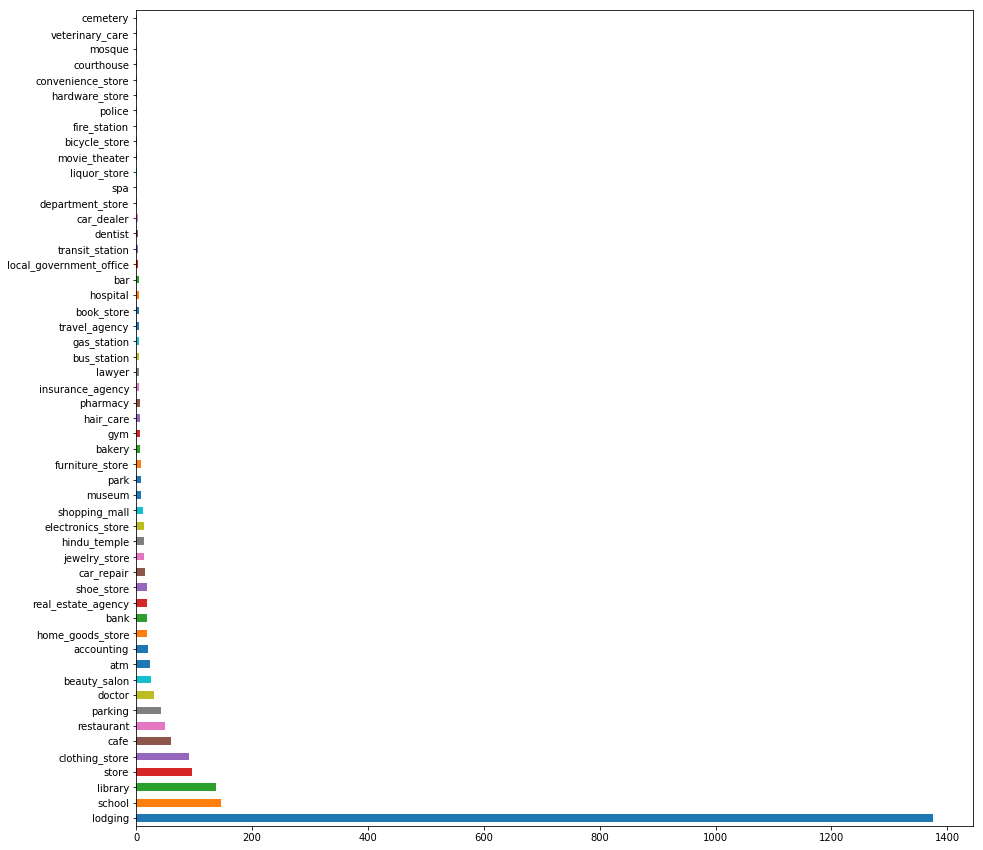

In [29]:
type_count = new_df.type.value_counts()
type_count.plot.barh(figsize=(15,15))

In [30]:
typ = "restaurant"

### Recommending various Point of Interests within a certain radius based on type of next activity to be performed by the user

In [36]:
current_loc = current_loc.replace(" ", "+")

geocode_url = "https://maps.googleapis.com/maps/api/geocode/json?address=" + current_loc + "&key=" + geocoding_api

response = requests.get(geocode_url)
data = json.loads(response.text)

current_lat = data['results'][0]['geometry']['location']['lat']
current_long = data['results'][0]['geometry']['location']['lng']

nearby_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json?location="

response = requests.get(nearby_url + str(current_lat) + "," + str(current_long) + "&radius=" + str(radius) + "&type=" + typ + "&key=" + places_api_web_service)

data = json.loads(response.text)

print ("Recommended places in your vicinity are: "+"\n")

for i in range (0, len(data['results'])):
    print(data['results'][i]['name'])
    
    if 'rating' in data['results'][i]:
        print ("Rating: " + str(data['results'][i]['rating']))
    else:
        print ("Rating: N.A.")
    print ("Address: " + (data['results'][i]['vicinity']))
    print ("\n")

Recommended places in your vicinity are: 

Domino's Pizza
Rating: 3.8
Address: Rajpur Road, Jakhan, Dehradun


Subway
Rating: 3.9
Address: LG-29, Pacific Mall, Rajpur Rd, Jakhan, Dehradun


Dunkin' Donuts
Rating: 4.2
Address: UG 03, Pacific Mall, Rajpur Rd, Dehradun


KFC
Rating: 4
Address: 65-A, Pacific Mall, Rajpur Road, Jakhan, Dehradun


Taste Of America
Rating: 3.8
Address: Pacific Mall,, Rajpur Road, Dehradun


Amritsari Express
Rating: 4.3
Address: Rajpur Road, Jakhan, Dehradun


Pizza Hut
Rating: 3.8
Address: S 13, Pacific Mall, Jakhan, Dehradun


Punjab Grill
Rating: N.A.
Address: Malsi, Dehradun


Cafe Coffee Day - Jakhan
Rating: 4.2
Address: 152, Inside The Axiom Building, Rajpur Road, Jakhan, Near Scholars Home School, Dehradun


Royal Restaurant
Rating: N.A.
Address: Rajpur Road, Doon Vihar, Jakhan, Dehradun


BMG- All Day Dining
Rating: 4
Address: Rajpur Road, Jakhan, Dehradun


Nautika
Rating: 4
Address: Rajpur Road, Jakhan, Dehradun


Burger King
Rating: 4.1
Address: 15